# **NN RECOMMENDER SYSTEM**
### **Huseyin Emir Can**

Here we start by importing libraries for getting the data.

Actually, I used data by uploading Google Colab from my laptop, 
because of my laptop's lack of ram.

Therefore, in order to be consistent and provide integrity in the code when you run, I searched and find this small downloading code to download Movielens 1M dataset. 

Here are the download code's imports:

In [ ]:
import io
import os
import math
import copy
import pickle
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen
from zipfile import ZipFile

import numpy as np
import pandas as pd

In [ ]:
# It also includes reading the data
# Data need to be uploaded to colab as ratings and movies
def read_data(path):
    if filename.stem == 'ratings':
        columns = ['userId', 'movieId', 'rating', 'timestamp']
    else:
        columns = ['movieId', 'title', 'genres']
    data = pd.read_csv(filename, sep='::', names=columns, engine='python')
    files[filename.stem] = data
    return files['ratings'], files['movies']

In [ ]:
columns = ['movieId', 'title', 'genres']
movies = pd.read_csv('/content/movies.dat', sep='::', names=columns, engine='python',encoding='latin-1')

columns = ['userId', 'movieId', 'rating', 'timestamp']
ratings = pd.read_csv('/content/ratings.dat', sep='::', names=columns, engine='python',encoding='latin-1')




Let's quickly check what we have in the dataset:


In [ ]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [ ]:
ratings.sample(5)

,userId,movieId,rating,timestamp
999565,6037,3469,4,956709327
876546,5294,1831,3,962763051
669608,4024,1214,5,965518430
91408,605,3408,4,975871874
904505,5469,2819,4,959895993


In [ ]:
movies.sample(5)

,movieId,title,genres
3169,3238,Eye of the Beholder (1999),Thriller
1685,1734,My Life in Pink (Ma vie en rose) (1997),Comedy|Drama
1658,1706,Harlem River Drive (1996),Drama
3845,3915,Girlfight (2000),Drama
2312,2381,Police Academy 4: Citizens on Patrol (1987),Comedy


In [ ]:
print('There are {} rows of data from {} users'.format(len(ratings), len(ratings.userId.unique())))

There are 1000209 rows of data from 6040 users


Let's do some preprocessing for out data.

Prepare it as df and encode users and movies as integer indices.

Here we used sklearn's LabelEncoder for this process.

In [ ]:
from sklearn.preprocessing import LabelEncoder

def create_df(df):

    # Encoding users and movies as integers
    user_ids=df['userId'].unique().tolist()
    user2user_encoded = {x: i for i, x in enumerate(user_ids)}
    userencoded2user = {i: x for i, x in enumerate(user_ids)}
    user_enc = LabelEncoder()
    df['user'] = user_enc.fit_transform(df['userId'].values)
    

    movie_ids = df["movieId"].unique().tolist()
    movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
    movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
    movie_enc = LabelEncoder()
    df['movie'] = movie_enc.fit_transform(df['movieId'].values)

    # Number of unique users and movies
    n_users = df['userId'].nunique()
    n_movies = df['movieId'].nunique()

    df['rating'] = df['rating'].values.astype(np.float32)

    # Min and Max ratings from the database
    # We will use these for normalization
    min_rating = min(df['rating'])
    max_rating = max(df['rating'])

    return n_users, n_movies, min_rating, max_rating, user2user_encoded, userencoded2user, movie2movie_encoded, movie_encoded2movie, df



In [ ]:
from sklearn.model_selection import train_test_split

# Create our df by calling create_df function & create X,y for split
n_users, n_movies, min_rating, max_rating, user2user_encoded, userencoded2user, movie2movie_encoded, movie_encoded2movie, df =create_df(ratings)

X = df[['user', 'movie']].values
y = df['rating'].values # our target


# Split by %90-%10 for train and test as we have 1M row data. 
# Test will have 100k row data.
# We could do %95-%5 but i prefer that way. As 50k row would be enough for test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=10)

# We didn't normalize our target(y) for first try, we will do it later
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((900188, 2), (100021, 2), (900188,), (100021,))

In [ ]:
print(f'Embeddings: {n_users} users, {n_movies} movies')
print(f'Dataset(user&movie ids) shape: {df.shape}')
print(f'Target(ratings) shape: {y.shape}')

print(f'We will use user and movie as features and rating as the target of our embedding based model.')

Embeddings: 6040 users, 3706 movies
Dataset(user&movie ids) shape: (1000209, 6)
Target(ratings) shape: (1000209,)
We will use user and movie as features and rating as the target of our embedding based model.


Now we will start our collaborative filtering model

Importing tensorflow and keras

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.regularizers import l2

import matplotlib.pyplot as plt

# Make users and movies into separate arrays in the training and test data for Keras input
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

# EmbeddingLayer as a calling class
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, Embedded):
        Embedded = layers.Embedding(self.n_items, 
                             self.n_factors, 
                             embeddings_initializer='he_normal',
                             embeddings_regularizer=l2(1e-6))(Embedded)
        Embedded = Reshape((self.n_factors,))(Embedded)
        return Embedded


def rec_Model(n_users, n_movies, embedding_size=50):
    #Creating an embedding layer having embedding vectors of user and item ids.
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, embedding_size)(user)
        
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, embedding_size)(movie)
    
    # Dot product for interactions between users and items
    interaction = Dot(axes=1)([u, m])

    # We used Adam for optimizer as learning_rate=0.001
    rec_model = Model(inputs=[user, movie], outputs=interaction)
    opt = Adam(learning_rate=0.001)

    # Computing loss as mean squared error
    rec_model.compile(loss='mean_squared_error', optimizer=opt)

    return rec_model #recommender model 

In [ ]:
model = rec_Model(n_users, n_movies)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        302000      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        185300      ['input_2[0][0]']                
                                                                                              

In [ ]:
history1 = model.fit(x=X_train_array, 
                      y=y_train, 
                      batch_size=1000, 
                      epochs=10, 
                      verbose=1, 
                      validation_data=[X_test_array, y_test])

Epoch 1/10
901/901 [==============================] - 7s 7ms/step - loss: 6.4116 - val_loss: 1.1369
Epoch 2/10
901/901 [==============================] - 6s 7ms/step - loss: 0.9597 - val_loss: 0.8906
Epoch 3/10
901/901 [==============================] - 6s 6ms/step - loss: 0.8620 - val_loss: 0.8538
Epoch 4/10
901/901 [==============================] - 6s 6ms/step - loss: 0.8322 - val_loss: 0.8352
Epoch 5/10
901/901 [==============================] - 6s 6ms/step - loss: 0.8124 - val_loss: 0.8217
Epoch 6/10
901/901 [==============================] - 6s 7ms/step - loss: 0.7948 - val_loss: 0.8125
Epoch 7/10
901/901 [==============================] - 6s 6ms/step - loss: 0.7772 - val_loss: 0.8020
Epoch 8/10
901/901 [==============================] - 6s 6ms/step - loss: 0.7607 - val_loss: 0.7957
Epoch 9/10
901/901 [==============================] - 6s 6ms/step - loss: 0.7463 - val_loss: 0.7899
Epoch 10/10
901/901 [==============================] - 6s 6ms/step - loss: 0.7318 - val_loss: 0.7830

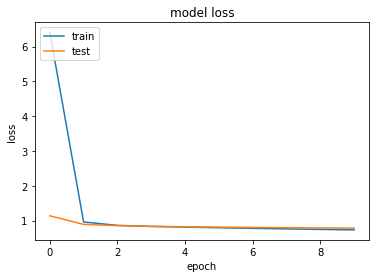

In [ ]:
plt.plot(history1.history["loss"])
plt.plot(history1.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

Now we add neural network to our model with a dropout and concatenatation

Actually I tried with more dense layers and dropouts but it didn't further improve our score

In [69]:
from keras.layers import Activation, Concatenate, Dense, Dropout
from keras import backend
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
 


def NNmodel(n_users, n_movies, embedding_size=50):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, embedding_size)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, embedding_size)(movie)
    
    # Concat on the embedding layers and dropout layer
    interaction = Concatenate()([u, m])
    interaction = Dropout(0.05)(interaction)

    # Dense layer with relu and sigmoid activation functions for interaction    
    interaction = Dense(10, kernel_initializer='he_normal')(interaction)
    interaction = Activation('relu')(interaction)
    interaction = Dropout(0.5)(interaction)
    
    interaction = Dense(1, kernel_initializer='he_normal')(interaction)
    interaction = Activation('sigmoid')(interaction)

    # Again used Adam with lr=0.001
    NNmodel = Model(inputs=[user, movie], outputs=interaction)
    opt = Adam(learning_rate=0.001)
    NNmodel.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae','accuracy',rmse])

    return NNmodel

In [79]:
model2 = NNmodel(n_users, n_movies)
model2.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_18 (Embedding)       (None, 1, 50)        302000      ['input_19[0][0]']               
                                                                                                  
 embedding_19 (Embedding)       (None, 1, 50)        185300      ['input_20[0][0]']               
                                                                                            

In [80]:
history2 = model2.fit(x=X_train_array, 
                      y=y_train, 
                      batch_size=1000, 
                      epochs=10, 
                      verbose=1, 
                      validation_data=(X_test_array, y_test))

Epoch 1/10
901/901 [==============================] - 9s 9ms/step - loss: 8.1756 - mae: 2.6297 - accuracy: 0.0560 - rmse: 2.6297 - val_loss: 7.8871 - val_mae: 2.5761 - val_accuracy: 0.0564 - val_rmse: 2.5761
Epoch 2/10
901/901 [==============================] - 8s 8ms/step - loss: 7.9318 - mae: 2.5848 - accuracy: 0.0561 - rmse: 2.5848 - val_loss: 7.8873 - val_mae: 2.5761 - val_accuracy: 0.0564 - val_rmse: 2.5761
Epoch 3/10
901/901 [==============================] - 8s 8ms/step - loss: 7.9293 - mae: 2.5843 - accuracy: 0.0561 - rmse: 2.5843 - val_loss: 7.8874 - val_mae: 2.5760 - val_accuracy: 0.0564 - val_rmse: 2.5760
Epoch 4/10
901/901 [==============================] - 8s 8ms/step - loss: 7.9279 - mae: 2.5840 - accuracy: 0.0561 - rmse: 2.5840 - val_loss: 7.8872 - val_mae: 2.5761 - val_accuracy: 0.0564 - val_rmse: 2.5761
Epoch 5/10
901/901 [==============================] - 8s 9ms/step - loss: 7.9272 - mae: 2.5839 - accuracy: 0.0561 - rmse: 2.5839 - val_loss: 7.8869 - val_mae: 2.5761 - 

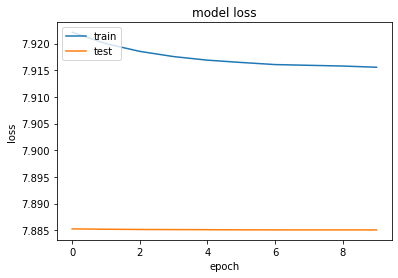

In [78]:
plt.plot(history2.history["loss"])
plt.plot(history2.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

Now final trick

We will try to normalize our target and let's see what will our NNmodel do

Normalize the target between 0 and 1. Makes it easy to train.

In [ ]:
y2 = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Again split data
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, train_size=0.9, random_state=10)

X_train.shape, X_test.shape, y2_train.shape, y2_test.shape

((900188, 2), (100021, 2), (900188,), (100021,))

In [70]:
model3 = NNmodel(n_users, n_movies)
model3.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, 1, 50)        302000      ['input_17[0][0]']               
                                                                                                  
 embedding_17 (Embedding)       (None, 1, 50)        185300      ['input_18[0][0]']               
                                                                                            

In [71]:
history3 = model3.fit(x=X_train_array, 
                      y=y2_train, 
                      batch_size=1000, 
                      epochs=5, 
                      verbose=1, 
                      validation_data=(X_test_array, y2_test))

Epoch 1/5
901/901 [==============================] - 10s 9ms/step - loss: 0.0600 - mae: 0.1953 - accuracy: 0.2504 - rmse: 0.1953 - val_loss: 0.0522 - val_mae: 0.1809 - val_accuracy: 0.2561 - val_rmse: 0.1809
Epoch 2/5
901/901 [==============================] - 8s 9ms/step - loss: 0.0553 - mae: 0.1869 - accuracy: 0.2549 - rmse: 0.1869 - val_loss: 0.0520 - val_mae: 0.1806 - val_accuracy: 0.2566 - val_rmse: 0.1806
Epoch 3/5
901/901 [==============================] - 8s 9ms/step - loss: 0.0549 - mae: 0.1861 - accuracy: 0.2553 - rmse: 0.1861 - val_loss: 0.0519 - val_mae: 0.1803 - val_accuracy: 0.2568 - val_rmse: 0.1803
Epoch 4/5
901/901 [==============================] - 8s 9ms/step - loss: 0.0548 - mae: 0.1856 - accuracy: 0.2554 - rmse: 0.1856 - val_loss: 0.0519 - val_mae: 0.1802 - val_accuracy: 0.2563 - val_rmse: 0.1802
Epoch 5/5
901/901 [==============================] - 8s 9ms/step - loss: 0.0548 - mae: 0.1855 - accuracy: 0.2554 - rmse: 0.1855 - val_loss: 0.0517 - val_mae: 0.1798 - val_

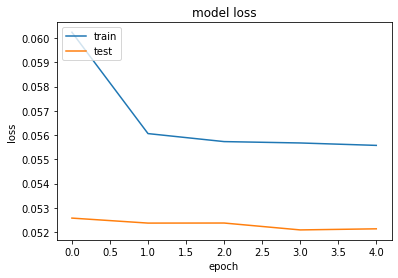

In [65]:
plt.plot(history3.history["loss"])
plt.plot(history3.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

Our loss dropped from 0.79 to 0.051 and with only just 5 epochs

> Girintili blok



## Movie Recommendation For a User By Our Model

In [ ]:
# Let us get a random user and see the top recommendations for that user
user_id = df.userId.sample(1).iloc[0]

# We need movies df this time
movie_df=movies
movies_watched_by_user = df[df.userId == user_id]

# We have movies watched by user, so we need movies not watched
movies_not_watched = movie_df[~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
movies_not_watched2 = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))
movies_not_watched3 = [[movie2movie_encoded.get(x)] for x in movies_not_watched2]

# Prepare user movie array for model prediction
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched3), movies_not_watched3))
user_movie_array2= [user_movie_array[:, 0], user_movie_array[:, 1]]

# Predict movies for user to recommend
ratings_for_user= model3.predict(user_movie_array2).flatten()

# Sort predicted movies
top_ratings_indices = ratings_for_user.argsort(axis=0)[-5:][::-1]

# Get movie ids
recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched3[x][0]) for x in top_ratings_indices]


# Print movies which are recommended by our model
print("----" * 11)
print(f"Top 5 movie recommendations for user: {user_id}")
print("----" * 11)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)


--------------------------------------------
Top 5 movie recommendations for user: 1153
--------------------------------------------
GoldenEye (1995) : Action|Adventure|Thriller
Secret Garden, The (1993) : Children's|Drama
Heavy (1995) : Drama|Romance
Deer Hunter, The (1978) : Drama|War
Fast, Cheap & Out of Control (1997) : Documentary


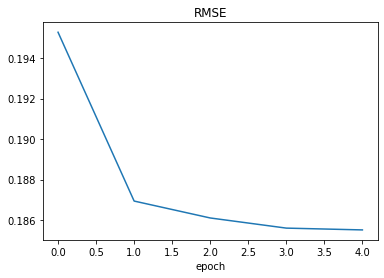

In [82]:
from matplotlib import pyplot
pyplot.plot(history3.history['rmse'])
plt.title("RMSE")
plt.xlabel("epoch")
pyplot.show()

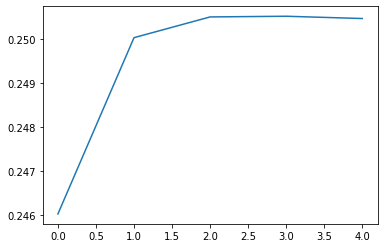

In [64]:
pyplot.plot(history3.history['accuracy'])
plt.title("Accuracy")
plt.xlabel("epoch")
pyplot.show()

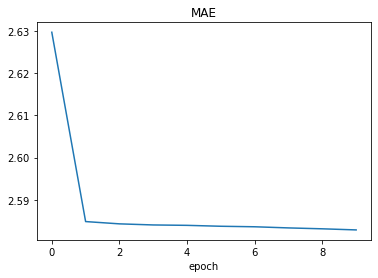

In [83]:
from matplotlib import pyplot
pyplot.plot(history2.history['mae'])
plt.title("MAE")
plt.xlabel("epoch")
pyplot.show()